## Exercise 6: ROC curves and image retrieval

In order to complete the exercise you have to present these files to the teaching assistant. Some assignments contain questions that require sketching, writing or manual calculation. Write these answers down and bring them to the presentation as well. The tasks that are written in bold are optional. Without completing them you can get at most 75 points for the exercise (the total number of points is 100 and results in grade 10). Each optional task has the amout of additional points written next to it, sometimes there are more optional exercises and you do not have to complete all of them.

### Introduction 

The exercise includes two assignments: In the first one you will get to know ROC curves that can be used to evaluate and compare classifiers and retrieval systems. In the second assignment you will implement and test several image retrieval systems that operate on different features and evalue them using ROC analysis.

In [1]:
%matplotlib notebook

# Importing necessary libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import models
import os
import tarfile
import urllib, urllib.request
from skimage import data, io, transform
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt
import cv2

### Assignment 1: The theory of ROC analysis

The purpose of this assignment is to learn the theory and practical use of ROC analysis. Therefore you should first read <a href="https://www.sciencedirect.com/science/article/pii/S016786550500303X">a paper about ROC curves</a> (*if you do not have access to ScienceDirect from home, then you can use <a href="https://box.vicos.si/borja/mms/Introduction_to_ROC_Analysis.pdf">this link</a> to obtain the paper*). While reading, pay special attention to sections $1$--$5$ and $7$--$8$. In the following tasks you will work on a given theoretical example of two classifiers ($C_1$ and $C_2$).

We have a set of samples that we wish to classify in one of two classes and a ground truth class of each sample (denoted as $0$ and $1$). For each sample a classifier gives us a score based on which we can determine to which class should the sample belong to (score closer to $0$ means class $0$, score closer to $1$ means class $1$). Below are the results for $8$ samples, their ground truth values ($\xi_\mathrm{id}$) and the score values for both classifiers ($\xi_{C_1}$ and $\xi_{C_2}$).

\begin{equation}
    \begin{array}{*{20}c}
            {\xi_\mathrm{id} = } & {\left[ {} \right.} & 1 & 0 & 1 & 1 & 1 & 0 & 0 & 0 & {\left. {} \right]}  \\
            {\xi_{C_1} = } & {\left[ {} \right.} & {0.5} & {0.3} & {0.6} & {0.22} & {0.4} & {0.51} & {0.2} & {0.33} & {\left. {} \right]}  \\
            {\xi_{C_2} = } & {\left[ {} \right.} & {0.04} & {0.1} & {0.68} & {0.22} & {0.4} & {0.11} & {0.8} & {0.53} & {\left. {} \right]}  \\
    \end{array}
\end{equation}

a) For the example above calculate and draw the ROC curves (by hand) for classifier $C_1$ as well as classifier $C_2$. Also calculate the area under the curve (AUC) for both classifiers. For the classifier $C_1$ select a decision threshold (working points) $\vartheta_{th1}=0.33$ and use it to calculate the confusion matrix and the $F$ measure score. Do the same thing for the classifier $C_2$ using a threshold value $\vartheta_{th2}=0.1$.

<b>Question:</b> Based on <a href="https://www.sciencedirect.com/science/article/pii/S016786550500303X">Fawcett theory</a> decide which classifier is better in the selected working points and motivate your decision. Which working point is optimal for each classifier?

<IPython.core.display.Javascript object>


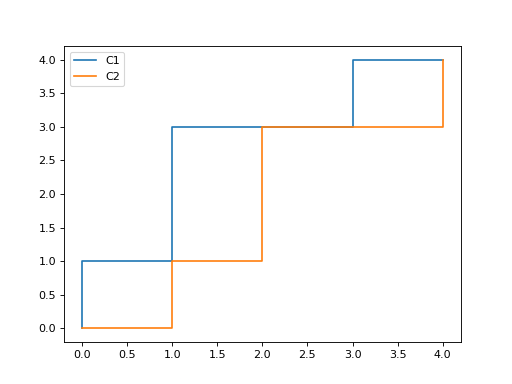

CONFUSION MATRIX ZA C1:
#=======#=======#=======#
#       #   p   #   n   #
#=======#=======#=======#
#   Y   #   3   #   1   #
#=======#=======#=======#
#   N   #   1   #   3   #
#=======#=======#=======#
F-measure: 0.75
AUC: 0.6875 

CONFUSION MATRIX ZA C2:
#=======#=======#=======#
#       #   p   #   n   #
#=======#=======#=======#
#   Y   #   3   #   3   #
#=======#=======#=======#
#   N   #   1   #   1   #
#=======#=======#=======#
F-measure: 0.5
AUC: 0.4375 

ANSWER: Boljši clasiffier je v našem primeru C1 kar je razvidno iz ROC grafa      oziroma tudi iz vrednosti AUC. Površina pod ROC krivuljo za C1 je večja, torej      so njegove napovedi v povprečju boljše.


In [12]:
# TODO
real = [1, 0, 1, 1, 1, 0, 0, 0]
C1 = [0.5, 0.3, 0.6, 0.22, 0.4, 0.51, 0.2, 0.33]
C2 = [0.04, 0.1, 0.68, 0.22, 0.4, 0.11, 0.8, 0.53]

CVse = [C1, C2]
thresholds = [0.33, 0.1]

ROCKrivulje = [[], []]

plt.figure()
for c in range(2):
    ###===================== SORTIRANJE =====================###
    sorted = []
    real_copy = real.copy()
    predictions = CVse[c]
    sorted = [i for i in predictions]

    for i in range(len(sorted)):
        for j in range(len(sorted)-1):
            if np.abs(sorted[j]) < np.abs(sorted[j+1]):
                sorted[j], sorted[j+1] = sorted[j+1], sorted[j]
                real_copy[j], real_copy[j+1] = real_copy[j+1], real_copy[j]
                
    ###===================== SESTAVLJANJE CONFUSION MATRIXA =====================###
    columns = ('p', 'n')
    rows = ('Y','N')
    tr = thresholds[c]
    vrednosti = [0, 0, 0, 0] # [TP, FP, TN, FN]
    for i in range(len(sorted)):
        if sorted[i] > tr:
            pricakovano = 1
            if real_copy[i] == pricakovano:
                vrednosti[0] += 1
            else:
                vrednosti[1] += 1
        else:
            pricakovano = 0
            if real_copy[i] == pricakovano:
                vrednosti[2] += 1
            else:
                vrednosti[3] += 1
    #print("[TP, FP, TN, FN]")
    #print(vrednosti)
    
    prec = vrednosti[0]/(vrednosti[0]+vrednosti[1])
    F = 2/(2/prec)
    
    print("CONFUSION MATRIX ZA C"+str(c+1)+":")
    print("#=======#=======#=======#")
    print("#       #   p   #   n   #")
    print("#=======#=======#=======#")
    print("#   Y   #   "+str(vrednosti[0])+"   #   "+str(vrednosti[1])+"   #")
    print("#=======#=======#=======#")
    print("#   N   #   "+str(vrednosti[3])+"   #   "+str(vrednosti[2])+"   #")
    print("#=======#=======#=======#")
    
    print("F-measure:", F)

    ###===================== RAČUNANJE POVRŠINE IN RISANJE GRAFA =====================###
    #print(real_copy, sorted)
    povrsina = 0.0
    stevec1 = 0
    stevec0 = 0
    x = [0]
    y = [0]
    enke = np.count_nonzero(real_copy) # enke == y os našega grafa
    nule = len(real_copy) - np.count_nonzero(real_copy) # nule == x os našega grafa
    #print(enke, nule)

    sorted.append(-100000000000) # dodamo zato da se izvede tudi na zadnji napovedi v tabeli

    for i in range(len(sorted)-1):
        #print(real_copy[i], sorted[i], povrsina)
        if sorted[i] == sorted[i+1]:
            if real_copy[i] == 1:
                stevec1+=1
            else:
                stevec0+=1
        else:
            if real_copy[i] == 1:
                stevec1+=1
            else:
                stevec0+=1
            if (stevec0 > 0 and stevec1 > 0):
                #print("DODAM VEČ ZAPORDNIH ENK IN NIČEL:", np.count_nonzero(real_copy[i:] == 0)*stevec1, "+", np.sqrt(stevec1**2 + stevec0**2))
                povrsina += np.count_nonzero(real_copy[i:])*stevec1 + 0.5*(stevec1 * stevec0)
            elif (stevec1 > 0):
                #print("DODAM VEČ ZAPOREDNIH ENK:", np.count_nonzero(real_copy[i:] == 0)*stevec1)
                povrsina += len(real_copy[i:]) - np.count_nonzero(real_copy[i:])*stevec1
            elif (stevec0 > 0):
                # DO NOTHING
                pass
            stevec0 = 0
            stevec1 = 0
            x.append(enke - np.count_nonzero(real_copy[i:]))
            y.append(nule - (len(real_copy[i:]) - np.count_nonzero(real_copy[i:])))
    
    x.append(4)
    y.append(4)
    
    ROCKrivulje[c].append(y)
    ROCKrivulje[c].append(x)
    #print(ROCKrivulje)
    
    plt.plot(y,x)
    #area = np.trapz(x, y)
    #print("area =", area/(enke*nule))
    print("AUC:", povrsina/(enke*nule), "\n")
plt.legend(["C1", "C2"])
plt.show()

print("ANSWER: Boljši clasiffier je v našem primeru C1 kar je razvidno iz ROC grafa\
      oziroma tudi iz vrednosti AUC. Površina pod ROC krivuljo za C1 je večja, torej\
      so njegove napovedi v povprečju boljše.")

b) You will now calculate ROC curves for <i>combined classifiers</i>. We have two binary classifiers, $C_1$ ($\vartheta_{th1}=0.33$) and $C_2$ ($\vartheta_{th2}=0.1$), which means that the classifier $C_1$ classifies a sample as class $1$, if its score is $\xi_{C_1}(\mathbf{x}_i) > \vartheta_{th1}$, otherwise it classifies it as class $0$, similarly can be said about classifier $C_2$. The first combined classifier $C_3$ can be obtained as the intersection of decisions of the two basic classifiers, $C_3 = C_1 \bigwedge C_2$ ($C_3$ classifies a sample as class $1$ if both basic classifiers classify it as class $1$). The second one can be obtained as an union of the decisions of the two basic classifiers, $C_4 = C_1 \bigvee C_2$ ($C_4$ classifies a sample as class $1$ if at least one of the basic classifiers classifies it as class $1$). For each combined classifier calculate and plot its point in the ROC space together with the ROC curves from previous tasks.

CONFUSION MATRIX ZA C1:
#=======#=======#=======#
#       #   p   #   n   #
#=======#=======#=======#
#   Y   #   3   #   1   #
#=======#=======#=======#
#   N   #   1   #   3   #
#=======#=======#=======#

CONFUSION MATRIX ZA C2:
#=======#=======#=======#
#       #   p   #   n   #
#=======#=======#=======#
#   Y   #   3   #   3   #
#=======#=======#=======#
#   N   #   1   #   1   #
#=======#=======#=======#

CONFUSION MATRIX ZA C3:
#=======#=======#=======#
#       #   p   #   n   #
#=======#=======#=======#
#   Y   #   2   #   1   #
#=======#=======#=======#
#   N   #   2   #   3   #
#=======#=======#=======#

CONFUSION MATRIX ZA C4:
#=======#=======#=======#
#       #   p   #   n   #
#=======#=======#=======#
#   Y   #   4   #   3   #
#=======#=======#=======#
#   N   #   0   #   1   #
#=======#=======#=======#

[[3.0, 1.0], [3.0, 3.0], [2.0, 1.0], [4.0, 3.0]]


<IPython.core.display.Javascript object>


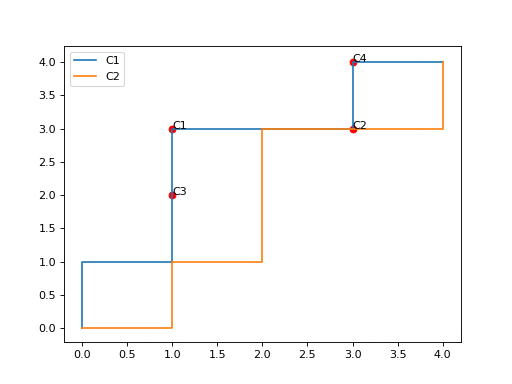

[[[0, 0, 0, 1, 1, 1, 2, 3, 3, 4], [0, 0, 1, 1, 2, 3, 3, 3, 4, 4]], [[0, 0, 1, 1, 2, 2, 2, 3, 4, 4], [0, 0, 0, 1, 1, 2, 3, 3, 3, 4]]]


In [13]:
# TODO
real = [1, 0, 1, 1, 1, 0, 0, 0]
C1 = [0.5, 0.3, 0.6, 0.22, 0.4, 0.51, 0.2, 0.33]
C2 = [0.04, 0.1, 0.68, 0.22, 0.4, 0.11, 0.8, 0.53]

thresholds = [0.33, 0.1]
pred1 = []
pred2 = []
presek = []
unija = []
for i in range(len(C1)):
    if C1[i]>thresholds[0] and C2[i]>thresholds[1]:
        pred1.append(1)
        pred2.append(1)
        presek.append(1)
        unija.append(1)
    elif C1[i]>thresholds[0] and C2[i]<=thresholds[1]:
        pred1.append(1)
        pred2.append(0)
        presek.append(0)
        unija.append(1)
    elif C1[i]<=thresholds[0] and C2[i]>thresholds[1]:
        pred1.append(0)
        pred2.append(1)
        presek.append(0)
        unija.append(1)
    else:
        pred1.append(0)
        pred2.append(0)
        presek.append(0)
        unija.append(0)
        
Cvsi = [pred1, pred2, presek, unija]
#print(Cvsi)

klas = []
for c in range(len(Cvsi)):
    vrednosti = [0, 0, 0, 0] # [TP, FP, TN, FN]
    predict = Cvsi[c]
    for i in range(len(predict)):
        if predict[i] == 1:
            if real[i] == 1:
                vrednosti[0] += 1
            else:
                vrednosti[1] += 1
        else:
            if real[i] == 1:
                vrednosti[3] += 1
            else:
                vrednosti[2] += 1
    
    
    print("CONFUSION MATRIX ZA C"+str(c+1)+":")
    print("#=======#=======#=======#")
    print("#       #   p   #   n   #")
    print("#=======#=======#=======#")
    print("#   Y   #   "+str(vrednosti[0])+"   #   "+str(vrednosti[1])+"   #")
    print("#=======#=======#=======#")
    print("#   N   #   "+str(vrednosti[3])+"   #   "+str(vrednosti[2])+"   #")
    print("#=======#=======#=======#\n")

    if (vrednosti[0]+vrednosti[1] == 0):
        obč = 1
    else:
        obč = vrednosti[0]/(vrednosti[0]+vrednosti[3])

    if (vrednosti[2]+vrednosti[3] == 0):
        spec = 1
    else:
        spec = vrednosti[1]/(vrednosti[1]+vrednosti[2])
    #print(obč, spec)
    klas.append([obč*4, spec*4])
        
print(klas)
x = [a[1] for a in klas]
y = [a[0] for a in klas]
labels = ['C1', 'C2', 'C3', 'C4']
plt.figure()
print(ROCKrivulje)
for plot in ROCKrivulje:
    plt.plot(plot[0], plot[1])
plt.scatter(x, y, c='#ff0000')
for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]))
    
plt.legend(["C1", "C2"])
plt.show()

c) Implement function <b>get_roc(scores, groundtruth)</b> that expects a vector <b>scores</b> ($\xi_\mathrm{score}$) and a vector <b>groundtruth</b> ($\xi_\mathrm{id}$) as an input and returns a ROC curve in matrix <b>R</b> as well as the area under the curve value in variable <b>AUC</b>. The ROC curve should be encoded as a $2 \times N$ matrix, the first row includes <i>true positive rate</i> values, the second row includes <i>false positive rate</i> values. You should study the <a href="https://www.sciencedirect.com/science/article/pii/S016786550500303X">Algorithm 1</a> described in the given paper for the implementation. Validate the correctness of the algorithm by computing the ROC curve on the data from the first task.

In [4]:
def get_roc(scores, groundtruth):
    #TODO
    pass

In [5]:
# TODO

d) <a href="https://www.sciencedirect.com/science/article/pii/S016786550500303X">Fawcett et al.</a> explains how to select an optimal working point for a classifier from a ROC curve. The threshold should be at the point on the curve that is the closest to the point $[0,1]$ in the ROC space. Extend your function <b>get_roc</b> so that it will also calculate the optimal working point for the ROC curve and that it will return its position and the corresponding threshold value and $F$ score value as additional results. Test your code on classifiers $C_1$ and $C_2$. Based on the AUC decide which classifier is performing better over all threshold values, based on the $F$ score at the optimal working point decide which classifier is better at this point. Write a script that calculates and draws ROC curves for classifiers $C_1$ and $C_2$ on the same plot, for both classifiers mark the optimal working point and set the title of the plot to display values of the thresholds, $F$ scores and AUC for both classifiers.

<IPython.core.display.Javascript object>


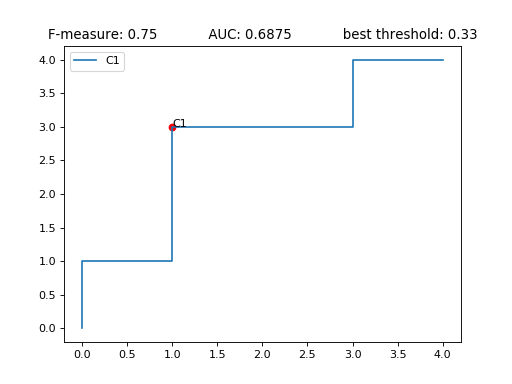

<IPython.core.display.Javascript object>


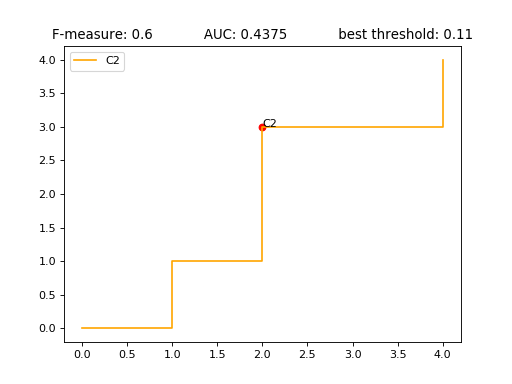

In [11]:
# TODO
real = [1, 0, 1, 1, 1, 0, 0, 0]
C1 = [0.5, 0.3, 0.6, 0.22, 0.4, 0.51, 0.2, 0.33]
C2 = [0.04, 0.1, 0.68, 0.22, 0.4, 0.11, 0.8, 0.53]

thresholds = [0.33, 0.11]

pred1 = []
pred2 = []
for i in range(len(C1)):
    if C1[i]>thresholds[0] and C2[i]>thresholds[1]:
        pred1.append(1)
        pred2.append(1)
    elif C1[i]>thresholds[0] and C2[i]<=thresholds[1]:
        pred1.append(1)
        pred2.append(0)
    elif C1[i]<=thresholds[0] and C2[i]>thresholds[1]:
        pred1.append(0)
        pred2.append(1)
    else:
        pred1.append(0)
        pred2.append(0)
        
Cvsi = [pred1, pred2]

klas = []
for c in range(len(Cvsi)):
    vrednosti = [0, 0, 0, 0] # [TP, FP, TN, FN]
    predict = Cvsi[c]
    for i in range(len(predict)):
        if predict[i] == 1:
            if real[i] == 1:
                vrednosti[0] += 1
            else:
                vrednosti[1] += 1
        else:
            if real[i] == 1:
                vrednosti[3] += 1
            else:
                vrednosti[2] += 1
       
    #print(vrednosti)
    if (vrednosti[0]+vrednosti[1] == 0):
        obč = 1
    else:
        obč = vrednosti[0]/(vrednosti[0]+vrednosti[3])

    if (vrednosti[2]+vrednosti[3] == 0):
        spec = 1
    else:
        spec = vrednosti[1]/(vrednosti[1]+vrednosti[2])
    #print(obč, spec)
    klas.append([obč*4, spec*4])
        
#print(klas)
x = [a[1] for a in klas]
y = [a[0] for a in klas]
plt.figure()
plot = ROCKrivulje[0]
plt.plot(plot[0], plot[1])
plt.scatter(x[0], y[0], c='#ff0000')
plt.annotate("C1", (x[0], y[0]))
plt.legend(["C1"])
plt.title("F-measure: 0.75 \
           AUC: 0.6875 \
           best threshold: 0.33")

plt.figure()
plot = ROCKrivulje[1]
plt.plot(plot[0], plot[1], c='#ffa500')
plt.scatter(x[1], y[1], c='#ff0000')
plt.annotate("C2", (x[1], y[1]))
plt.legend(["C2"])
plt.title("F-measure: 0.6 \
           AUC: 0.4375 \
           best threshold: 0.11")
plt.show()

### Assignment 2: Image retrieval using histograms and correlation

In this assignment you will implement several image retrival systems. The input to the system is a query image and the system should return the images in the database sorted by similarity to the query image. For each approach you will have to extract features from all the images, then compare your query image to all of the database images.
You will also have to compare the performance of different features over all the images in your dataset by calcualting an $N \times N$ similarity matrix.

You will test your retrieval systems on the <a href="http://www.vision.caltech.edu/Image_Datasets/Caltech101/">Caltech 101 dataset</a>. It consists of approximately 9000 color images from 101 classes. You can use the funtion <b>prepare_caltech</b> to extract the images and their corresponding classes. The function returns a list of images along with the corresponding class labels. You can modify it to only extract (or ignore) specific classes and/or to resize the images for faster processing if you wish. For developing the system you are advised to use a smaller subset of classes with a smaller number of samples to speed up the computation (or alternatively, a subset of easier classes, e.g. <i>stop_sign</i>, <i>faces</i>, <i>strawberry</i> etc.).

In [7]:
# Download Caltech101 dataset and unzip it
url = '101_ObjectCategories.tar.gz'

#file_tmp = urllib.request.urlretrieve(url, filename=None)[0]
base_name = os.path.basename(url)

file_name, file_extension = os.path.splitext(base_name)
tar = tarfile.open(url)
tar.extractall(file_name)
print("Done!")

Done!


In [8]:
def prepare_caltech(n_samples = 10):
    # Loads images from caltech_101 dataset and stores their classes
    # uses n_samples images from each class
    # only uses color images from each class
    
    # List of images
    images_list = []
    
    # Corresponding list of classes
    classes_list = []
    
    
    categories = os.walk('101_ObjectCategories.tar/101_ObjectCategories')

    is_first = 1
    for subdir_info in categories:
        if(is_first):
            is_first = 0
            
        else:
            dir_name = subdir_info[0].split('/')
            if(dir_name[-1] != 'BACKGROUND_Google'):
                
                tmp_images_list = [f for f in os.listdir(subdir_info[0]) if os.path.isfile(os.path.join(subdir_info[0], f))]
                
                tmp_counter = 0
                for image in tmp_images_list:
                    tmp_img = io.imread(os.path.join(subdir_info[0], image))
                    if(len(tmp_img.shape) == 3):
                        if(tmp_counter < n_samples):
                            images_list.append(tmp_img)
                            classes_list.append(dir_name[-1])
                            tmp_counter += 1
                    
    
    return images_list, classes_list

a) Implement the classifier based on color histograms. Write a function that computes 3D color histograms for all images in your database. Use the numpy function <b>histogramdd</b> in the RGB color space, then reshape the $3$D histograms to $1$D histograms and stack them together in a $2$D matrix (the matrix is composed in a way that the $i$-th row includes the histogram of the $i$-th image)..

To compute the distance between the reference histogram and every other histogram in the database you will use Hellinger distance that is defined as:

\begin{equation}
H(\mathbf{h}_1,\mathbf{h}_2) = \sqrt{  \frac{1}{2} \sum_{i=0}^{N-1} \Big( \sqrt{h_1(i)} - \sqrt{h_2(i)} \Big)^2 }.
\end{equation}

Note that low values of Hellinger distances signify high similarity while high values signify low similarity. This is exactly the opposite to what is expected by your ROC curve function that you will use in the following tasks. This can be fixed by redefining the histogram distance measure. If we assume that $H(\mathbf{h}_1,\mathbf{h}_2)$ denotes the Helliner distance between histograms $\mathbf{h}_1$ and $\mathbf{h}_2$, we can define the new distance simply as

\begin{equation}
\rho(\mathbf{h}_1,\mathbf{h}_2) = 1 - H(\mathbf{h}_1,\mathbf{h}_2).
\end{equation}

Write a script that tests your system by loading the database (use $8$ bins per color channel), using the fifth image in the database as a reference image. Compute the distances to all other images, sort the distances and display the first five matches and the reference image in a same figure.

In [9]:
# Example usage of "histogramdd" function:
#
# Load an image
example_image = io.imread("101_ObjectCategories.tar/101_ObjectCategories/airplanes/image_0001.jpg")
# Reshape image of size (h, w, 3) to (h * w, 3)
example_image_reshaped = np.reshape(example_image, (example_image.shape[0] * example_image.shape[1], 3))
# Compute histograms for each color channel (and normalise it)
H, _ = np.histogramdd(example_image_reshaped, bins = 8, normed = True)
print(example_image_reshaped.shape, H.shape)

(65272, 3) (8, 8, 8)


<IPython.core.display.Javascript object>


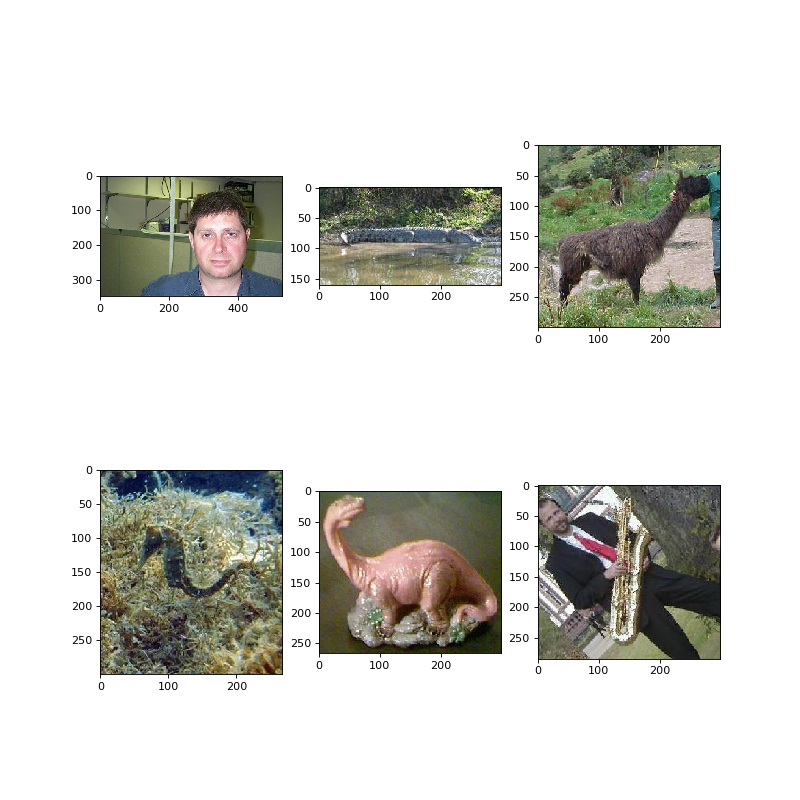

In [66]:
# TODO
def helinger (h1, h2):
    return np.sqrt(np.sum(np.power(np.sqrt(h1)-np.sqrt(h2), 2))*0.5)

slika1 = io.imread("101_ObjectCategories.tar/101_ObjectCategories/Faces/image_0005.jpg")
slika1_re = np.reshape(slika1, (slika1.shape[0] * slika1.shape[1], 3))
H1, _ = np.histogramdd(slika1_re, bins = 8, normed = True)
H1 = np.reshape(H1, (H1.shape[0] * H1.shape[1] * H1.shape[2]))

images_list, classes_list = prepare_caltech(10)
razdalje = []
indeksi = []
for i, image in enumerate(images_list):
    slika2_re = np.reshape(image, (image.shape[0] * image.shape[1], 3))
    H2, _ = np.histogramdd(slika2_re, bins = 8, normed = True)
    H2 = np.reshape(H2, (H2.shape[0] * H2.shape[1] * H2.shape[2]))
    razdalje.append(1-helinger(H1, H2))
    indeksi.append(i)

for i in range(len(razdalje)):
    for j in range(len(razdalje)-1):
        if np.abs(razdalje[j]) < np.abs(razdalje[j+1]):
            razdalje[j], razdalje[j+1] = razdalje[j+1], razdalje[j]
            indeksi[j], indeksi[j+1] = indeksi[j+1], indeksi[j]
_, ax = plt.subplots(2, 3, figsize=(10, 10))
ax[0][0].imshow(slika1)
for i in range(1, 6):
    #print(i//3, i%3)
    ax[i//3][i%3].imshow(images_list[indeksi[i-1]])

b) Implement a system that uses normalized cross-correlation of grayscale images. The normalized cross-correlation between two sequences of same size $\mathbf{X}$ and $\mathbf{Y}$, denoted as $NCC(\mathbf{X},\mathbf{Y})$ is defined as scalar product between normalized sequences:

\begin{equation}
NCC(\mathbf{X},\mathbf{Y}) = \frac{1}{N} \frac{\sum  (x_i - \bar{x}) (y_i - \bar{y})}{ \Big(\sqrt{ \frac{1}{N} \sum (x_i - \bar{x})^2 } \Big) \Big(\sqrt{ \frac{1}{N} \sum (y_i - \bar{y})^2 } \Big) }.
\end{equation}

where $\bar{x}$ and $\bar{y}$ denote the mean values of the elements in the sequences. Sequences are more similar if the correlation is higher. We can compute normalized cross-correlation for grayscale images of same size if we reshape them into vectors of intensity values. Repeat the testing of the system in the same manner than in the previous task, load images, convert them to grayscale, select a reference image, compute the distances and display the first five matches. What is the system sensitive to?

More information is available <a href="http://en.wikipedia.org/wiki/Cross-correlation">here</a>.

<IPython.core.display.Javascript object>


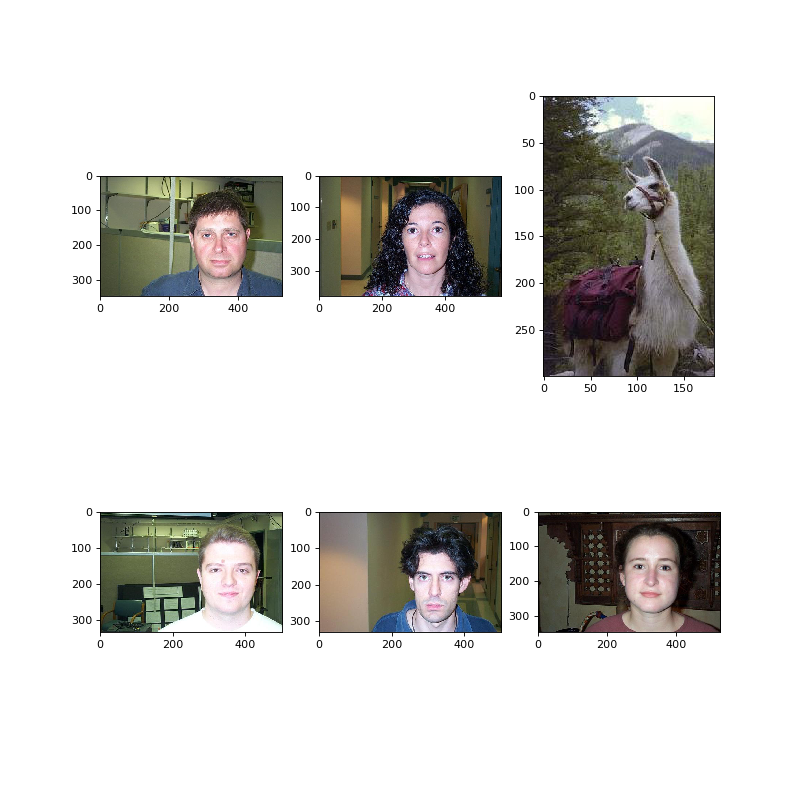

In [39]:
# TODO
def ncc(slika1_gray, slika2_gray):
    X = np.reshape(slika1_gray, (slika1_gray.shape[0] * slika1_gray.shape[1]))
    Y = np.reshape(slika2_gray, (slika2_gray.shape[0] * slika2_gray.shape[1]))
    x = np.average(X)
    y = np.average(Y)
    N = len(X)
    ncc = (1/N) * np.sum((X-x)*(Y-y))/((np.sqrt((1/N)*np.sum(np.power((X-x),2))))*(np.sqrt((1/N)*np.sum(np.power((Y-y),2)))))
    return ncc
    
slika1 = io.imread("101_ObjectCategories.tar/101_ObjectCategories/Faces/image_0005.jpg")
slika1_gray = np.mean(slika1, 2)

#images_list, classes_list = prepare_caltech(100)
NCCrazdalje = []
NCCindeksi = []
for i, image in enumerate(images_list):
    slika2_gray = np.mean(image, 2)
    minx = min(slika1_gray.shape[0], slika2_gray.shape[0])
    miny = min(slika1_gray.shape[1], slika2_gray.shape[1])
    NCCrazdalje.append(ncc(slika1_gray[0:minx, 0:miny], slika2_gray[0:minx, 0:miny]))
    NCCindeksi.append(i)


for i in range(len(NCCrazdalje)):
    for j in range(len(NCCrazdalje)-1):
        if np.abs(NCCrazdalje[j]) < np.abs(NCCrazdalje[j+1]):
            NCCrazdalje[j], NCCrazdalje[j+1] = NCCrazdalje[j+1], NCCrazdalje[j]
            NCCindeksi[j], NCCindeksi[j+1] = NCCindeksi[j+1], NCCindeksi[j]
_, ax = plt.subplots(2, 3, figsize=(10, 10))
ax[0][0].imshow(slika1)
for i in range(1, 6):
    #print(i//3, i%3)
    ax[i//3][i%3].imshow(images_list[NCCindeksi[i-1]])

c) Implement a retrieval system that uses CNN features to calculate image similarity. You will need the <b>PyTorch</b> library and a pretrained neural network of your choice. Note that architectures of the models are different and you need to check the model documentation to find out which layer contains useful features (but generally it is the penultimate layer). Its features should be one dimensional vectors that you can compare using the Hellinger distance. Plot the ROC curve for the system and comment on its performance related to the NCC and color histogram systems. Help yourself with the sample code below.

In [38]:
# Get pretrained ALEXNET model (you can also use other models)
# Full list of pretrained models is available at: https://pytorch.org/docs/stable/torchvision/models.html
model = models.alexnet(pretrained=True)

# Remove last fully-connected layer (Second to last layer usually contains useful features)
new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
model.classifier = new_classifier


# Read an image (we will use PIL library for loading the image)
image = Image.open("101_ObjectCategories.tar/101_ObjectCategories/airplanes/image_0001.jpg")

# Image transforms (for preprocessing)
# Note: You must check the documentation of your chosen model to see what kind of 
#       preprocessing procedure is required   
transform = transforms.Compose([
    transforms.Resize(256), # Resize the image to 256x256
    transforms.CenterCrop(224), # Central crop the image to 224x224
    transforms.ToTensor(), # Convert it to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Subtract mean value
                         std=[0.229, 0.224, 0.225])  # And normalize it using the std value
])

# Preprocess the input image and prepare a batch to be passed to the model
image_preprocessed = transform(image)
inference_batch = torch.unsqueeze(image_preprocessed, 0)

# Put the model in EVAL (inference) mode
model.eval()

# Perform the inference on the given batch
feature_vector = model(inference_batch)

# Show values of the feature_vector tensor
print(feature_vector)
# Show the shape of the feature_vector tensor
# Note: It should be a one dimensional tensor/vector
print(feature_vector.shape)  

# Convert tensor vector to numpy
# Use this to check image similarities
feature_vector_numpy = feature_vector.detach().numpy()

# Uncomment to print the non-truncated feature vector
# with np.printoptions(threshold=np.inf):
print(feature_vector_numpy)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/jovyan/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:04<00:00, 60.3MB/s] 


tensor([[0.0000, 0.0000, 0.1124,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward1>)
torch.Size([1, 4096])
[[0.         0.         0.11241658 ... 0.         0.         0.        ]]


<IPython.core.display.Javascript object>


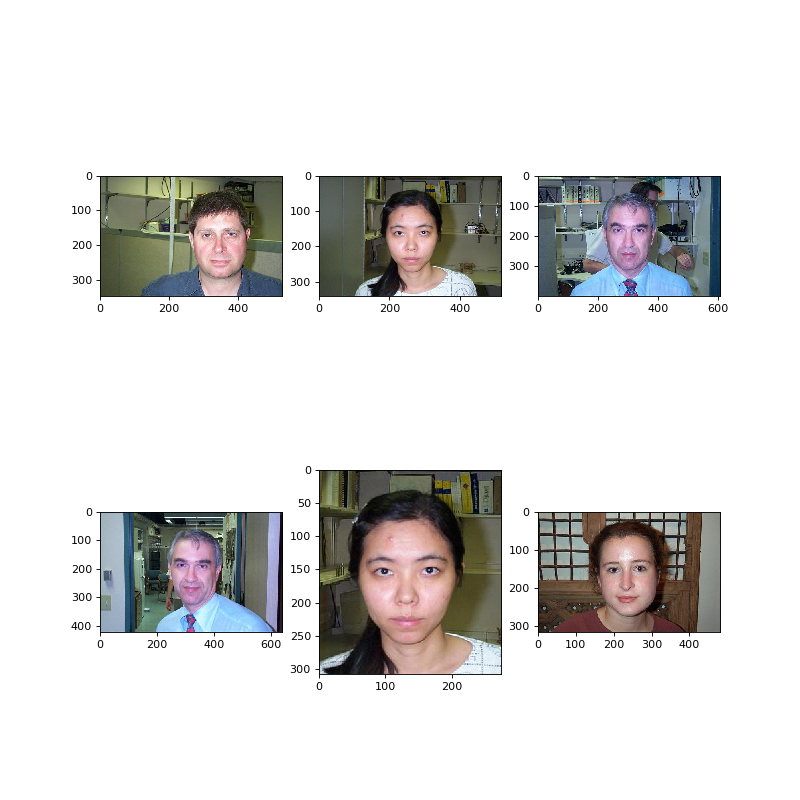

In [65]:
# TODO
slika1 = Image.open("101_ObjectCategories.tar/101_ObjectCategories/Faces/image_0005.jpg")
slika1_preprocessed = transform(slika1)
inference_batch = torch.unsqueeze(slika1_preprocessed, 0)
model.eval()
feature_vector = model(inference_batch)
feat1 = feature_vector.detach().numpy()

#images_list, classes_list = prepare_caltech(100)
CNNrazdalje = []
CNNindeksi = []
for i, img in enumerate(images_list):
    image = Image.fromarray(img)
    image_preprocessed = transform(image)
    inference_batch = torch.unsqueeze(image_preprocessed, 0)
    model.eval()
    feature_vector = model(inference_batch)
    feat2 = feature_vector.detach().numpy()
    #print(feat1, feat2)
    CNNrazdalje.append(10-helinger(feat1[0]/max(max(feat1[0]), max(feat2[0])), feat2[0]/max(max(feat1[0]), max(feat2[0]))))
    #print(CNNrazdalje)
    CNNindeksi.append(i)


for i in range(len(CNNrazdalje)):
    for j in range(len(CNNrazdalje)-1):
        if np.abs(CNNrazdalje[j]) < np.abs(CNNrazdalje[j+1]):
            CNNrazdalje[j], CNNrazdalje[j+1] = CNNrazdalje[j+1], CNNrazdalje[j]
            CNNindeksi[j], CNNindeksi[j+1] = CNNindeksi[j+1], CNNindeksi[j]
_, ax = plt.subplots(2, 3, figsize=(10, 10))
ax[0][0].imshow(slika1)
for i in range(1, 6):
    #print(i//3, i%3)
    ax[i//3][i%3].imshow(images_list[CNNindeksi[i-1]])

d) <b>(5 points)</b> Extend the histogram method by including spatial information. Divide the input image into subregions, calculate the histogram for reach region, then concatenate the histograms into a final feature vector. Experiment with different numbers of subregions and comment on the performance of the new method.

In [ ]:
# TODO

e) <b>(15 points)</b> Implement an image retrieval system of your own design that will outperform both the histogram and the NCC systems. Create something unique with the methods of your choosing. You have to prove the system's performance using ROC curves.

In [ ]:
# TODO

f) The image retrieval systems can currently return distances between each image in the database to the reference image. If we want to build a binary classifier we have to determine the optimal threshold that can be used to decide if a classifier belongs to the class of the reference image or not. We will use ROC analysis that you have implemented in the previous assignment. Use the ROC curves to determine optimal threshold. You can use an image in the database as a reference image and compute distances to every other image in the dataset. If we select the first image we can generate a ROC curve for that image, however, this curve only tells us the properties of the system for this input and may not be generalizable. If we select a different image we can get a completely different ROC curve with a different optimal point. Instead, use the following procedure to compute the ROC curve over all images in the database.

<ol>
    <li>Load the database.</li>
    <li>For each image in the database:
        <ol>
            <li>Use the selected image as a reference image.</li>
            <li>Compute the distance between the reference image and the remaining images in the database and store the distances to vector $\vartheta_\mathrm{score}$<br>(the vector must not include distance to the reference image itself).</li>
            <li>Use the provided label ground truth data to compose a vector of binary ground truth for the given reference image by comparing it to the class of the reference image. Save the binary ground truth to vector $\vartheta_\mathrm{class}$.</li>
            <li>Extend the overall vectors for scores and ground truth by appending the new data: $\varphi_\mathrm{class} = \varphi_\mathrm{class} + \vartheta_\mathrm{class}$ and $\varphi_\mathrm{score} = \varphi_\mathrm{score} + \vartheta_\mathrm{score}$.</li>
        </ol>
    <li>Use the composed overall vectors $\varphi_\mathrm{score}$ and $\varphi_\mathrm{class}$ to compute the ROC curve.</li>
</ol>

Evaluate all three systems by plotting their ROC curves and compare them. Determine the optimal threshold value, plot it in the ROC space (on top of the ROC curve). Do not forget to label the axes of the plot.

In [ ]:
# TODO

g) <b>(20 points)</b> Implement a bag-of-words approach for image retrieval. First, extract local features from each image (you can use SIFT or something similar), then generate a codebook via a clustering method (as described <a href="https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision#Codebook_generation">here</a>). The image feature vectors are then histograms of the codewords and can be used for comparison. See <a href="https://arxiv.org/abs/1304.5168">the paper</a> for further info on implementation details.

In [ ]:
# TODO